# Section 7. Challenges in generalization and extrapolation

Regression, like other supervised ML methods, is mainly designed for making predictions rather than determining existing relationships between features. However, by post-processing the obtained model parameters $\boldsymbol{\theta}$, we can uncover some underlying rules or relationships in the data we are analyzing. In this sense, we may even rediscover known physical laws in the form of governing equations. To achieve this, the obtained model needs to be interpretable, meaning it can explain why data behaves in a certain manner. An interpretable model not only has good generalization capabilities but also good expressive ability for extrapolation.

Consider the example in Section 3 involving data generated from a combination of trigonometric functions with additive noise. The example highlighted that regression is more nuanced than simply choosing a model and performing a least-square fit. The selection of the model itself is crucial for achieving better predictions and interpretable descriptions of the data.

In the example, we observed that choosing an "optimal" polynomial degree resulted in a model that interpolated the test data well. However, if the polynomial degree is too large or too small, the model may overfit or underfit the training data, respectively, leading to poor generalization for new data points. To address this issue, we employed regularized regression models such as LASSO. With regularization, we were able to identify a good approximation of the true trigonometric model hidden in the noisy data.

Why does a regularized regression model seem to have more predictive power than a straightforward nonlinear regression model with a large number of polynomial terms? The answer lies in Occam's razor, a principle of parsimony. According to Occam's razor, among different competing models that make the same predictions, the simpler one is more likely to be true. This principle is widely used in science, favoring simpler explanations. Regularized regression adheres to this principle by discouraging the inclusion of numerous polynomial terms and promoting model simplicity. Additionally, regularization helps prevent overfitting and ensures stability in the model. High-dimensional polynomial models tend to suffer from instability due to multicollinearity, which occurs when independent variables are highly correlated with each other.

While some benefits of regularization can be achieved with low-degree polynomial models without resorting to regularization, these models often underfit the training data and lack expressive power. It is worth noting that successful machine learning models often exhibit a certain degree of benign overfitting or overparametrization 4. Regularized regression models strike a balance between complexity and simplicity, offering significant predictive power by selecting relevant features.

In the example involving LASSO, Ridge, and Elastic Net regression, we demonstrated the interpolating power of regularized regression models. However, it is important to further assess their interpretability and potential to provide insights for identifying and discovering patterns and equations hidden within datasets.

## Interpretable models and *where* to find them

This application deals with the investigation of whether it is possible or not to discover interpretable models (governing equations) with extrapolative power using (regularized) regression methods. In particular, we mimic virtual experiments governed by a very simple equation and consider additive noise simulating virtual statistical errors in a hypothetical data acquisition system.

The underlying governing equation is the (one-dimensional) projectile motion, which is the solution of the second-order ordinary differential equation $\ddot{x}(t) + g = 0$:

\begin{equation*}
    x(t) = x(0)+\dot{x}(0) t-\frac{1}{2} g t^2,
\end{equation*}

where $x$, $\dot{x}$, and $\ddot{x}$ are the trajectory, velocity, and acceleration of the projectile, respectively; $t$ is the time, and $g$ is the gravitational acceleration. The code hereinafter integrates the differential equation with initial conditions: $x(0) = 0$ and $\dot{x}(0) = 5$. Being interested in making predictions within the range of values of some training data and outside of it, we generate the data and split them into interpolation ($x_i$ and $y_i$) and extrapolation ($x_e$ and $y_e$) sets.

We start by import the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
np.random.seed(42)

colorb=(0.20392156862745098, 0.43137254901960786, 0.7529411764705882)
colorr = (0.9333333333333333, 0.11372549019607843, 0.13725490196078433)

def projectile_motion(t, y):
    # Equations of motion
    dydt = y[1]  # velocity
    dvdt = -g   # acceleration
    return [dydt, dvdt]
# Initial conditions
n_snapshots = 200
x0 = 0.0  # meters
v0 = 5.0  # meters per second
g = 9.81  # acceleration due to gravity
t0 = 0.0 # initial t
tf = 1.0 # final t
# time points solution
t = np.linspace(t0, tf, n_snapshots)
# solve ODE
sol = solve_ivp(projectile_motion, [t0, tf], [x0, v0], t_eval=t)
# define independent and dependent variables
X = np.float32(t)
y = np.float32(sol.y[0])
n = n_snapshots//2
xi = X[:n] # train time
xe = X[n:2*n] # test time
ytrain = y[:n] # train x = [0,0.5]
ytest = y[n:2*n]  # test x = [0.5,1]

We continue by training a set of $n$ polynomial regression models of degree 20. Every model is trained against dependent variables lying between 0 and 1 (xi) and dependent variables with a normally distributed measurement noise, randomly selected at each loop (fni). In a nested for loop, we store the MSE values between the models predictions and the quadratic function, without measurement noise, for values of the independent variables in the interpolation (mse_int) and extrapolation (mse_ext) range.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

degree = 20# number of model terms
mse_int = np.zeros((n,degree))
mse_ext = np.zeros((n,degree))
poly_features = PolynomialFeatures(degree=degree, include_bias=False)

xi_poly = poly_features.fit_transform(np.expand_dims(xi,1))
xe_poly = poly_features.fit_transform(np.expand_dims(xe,1))

for deg in range(degree):
    xi_poly_ = xi_poly[:,:deg+1]
    xe_poly_ = xe_poly[:,:deg+1]
    for j in range(n):
        fni = ytrain + 0.3*np.random.normal(0,1,n) # y with normal noise     
        lin_reg = LinearRegression() # model
        lin_reg.fit(xi_poly_,fni) # fit for x in [-0.5,1]
        ynai = lin_reg.predict(xi_poly_)
        ynae = lin_reg.predict(xe_poly_) # fit for t in [0.5,1]
        mse_int[j,deg] = mean_squared_error(ytrain,ynai) # MSE train
        mse_ext[j,deg] = mean_squared_error(ytest,ynae) # MSE val

The Figure below shows the MSE of the set of model in the interpolation and extrapolation ranges. The results are clear: our set of models is massively overfitting the data with measurement noise and cannot generalize. When attempting to extrapolate beyond the range observed in the training data, we are confronted with substantial errors, as shown in Figure. The logarithmic plot illustrates the exponential growth of the error as the polynomial degree increases, reaching magnitudes as high as $10^{6}$. This demonstrates the inability of overfitted models to make predictions in the extrapolation range. Thus, we can say that (non-regularized) polynomial regression does not offer an interpretable model for this simple case (except an obvious second-order polynomial).

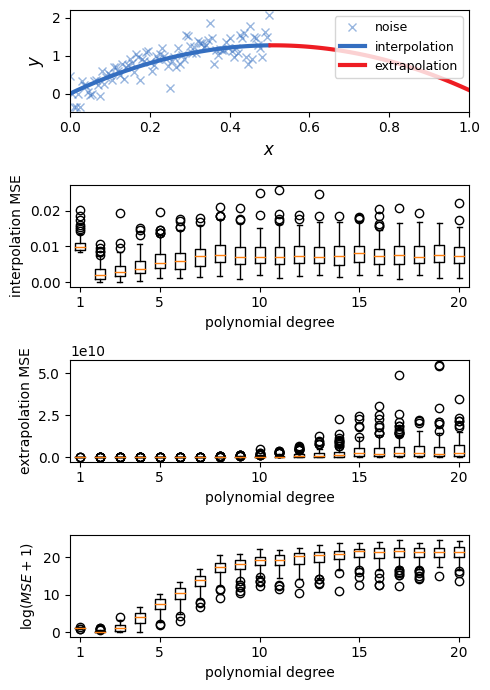

In [3]:
fig = plt.figure(dpi=100, figsize=(5, 7), tight_layout=True)
axs = fig.subplots(4)
axs = axs.reshape(-1)

axs[0].plot(xi, ytrain + 0.3*np.random.normal(0,1,n),'x',alpha=0.5,color=colorb,markersize=6,label='noise')
axs[0].plot(xi,ytrain,color=colorb,linewidth=3,label='interpolation')
axs[0].plot(xe,ytest,color=colorr,linewidth=3,label='extrapolation')
axs[0].legend(loc='best',fontsize="9")
axs[0].set_ylabel('$y$',fontsize="12")
axs[0].set_xlabel('$x$',fontsize="12")

axs[1].boxplot(mse_int)

axs[2].boxplot(mse_ext)
axs[3].boxplot(np.log(mse_ext+1))

for i in range(3):
    axs[i+1].set_xticks((1,5,10,15,20))
    axs[i+1].set_xticklabels((1,5,10,15,20))
axs[0].set_xlim(0,1.)
fig.patch.set_facecolor('white')

axs[1].set_ylabel('interpolation MSE',fontsize="10")
axs[2].set_ylabel('extrapolation MSE',fontsize="10")
axs[3].set_ylabel('$\log(MSE+1)$',fontsize="10")
axs[1].set_xlabel('polynomial degree',fontsize="10")
axs[2].set_xlabel('polynomial degree',fontsize="10")
axs[3].set_xlabel('polynomial degree',fontsize="10")
plt.show()

Let us continue by employing **cross-validation** to mitigate the effects of overfitting. We extend our set of polynomial regression models -- denoted with pinv, diminutive of pseudoinverse -- with regularized ones. The code below performs 100-fold cross-validation for the same noisy data sets for the three different regression models (pinv, LASSO, and Ridge) and stores the obtained parameters. Note that, as the measurement noise is randomly select for each $k$ fold, the training data points may be considered as virtual experimental measurements of our simplified system.

**Cross-validation**
In $k$-fold cross validation, the training data is randomly partitioned into $k$ partitions (or folds). Each partition is used to construct a regression model $\hat{y}_{(l)} = f_{\boldsymbol{\theta}_{(l)}} (\mathbf{x}_{(l)})$ for $l = 1, 2, \cdots , k$. Then, the final, cross-validated model is constructed by averaging the values of the parameters obtained from each fold $\boldsymbol{\theta}= 1/k \sum_{l=1}^k \boldsymbol{\theta}_{(l)}$.

In [4]:
from sklearn.linear_model import Lasso,Ridge
from sklearn.model_selection import KFold
nfolds = 100
lin_reg = LinearRegression() # linear model
lasso = Lasso(alpha=3e-4) # LASSO model
ridge = Ridge(alpha=3e-4) # Ridge model
k_fold = KFold(nfolds)
# initialize for storing parameters 
lasso_params = np.zeros((nfolds,degree+1))
ridge_params = np.zeros((nfolds,degree+1))
lin_params = np.zeros((nfolds,degree+1))
for k, (train, test) in enumerate(k_fold.split(xi_poly, ytrain)):
    fni = ytrain + 0.3*np.random.normal(0,1,n) # y with normal noise       
    lin_reg.fit(xi_poly[train], fni[train]) # fit lin
    ridge.fit(xi_poly[train], fni[train]) # fit RIdge
    lasso.fit(xi_poly[train], fni[train]) # fit LASSO
    # store models parameters
    lin_params[k,0] = lin_reg.intercept_
    lin_params[k,1:] = lin_reg.coef_
    ridge_params[k,0] = ridge.intercept_
    ridge_params[k,1:] = ridge.coef_
    lasso_params[k,0] = lasso.intercept_
    lasso_params[k,1:] = lasso.coef_    

The Figure below plots the values of the parameters $\boldsymbol{\theta}$ obtained from the above code, for $k$-th fold ($k=2$, $10$, and $100$). Note how the parameters of the standard regression model explode, with values of the order of $10^{5}$, independently of the number of folds. The phenomenon is intrinsic to polynomial regression which blows up as the polynomial degree is increased and further enhanced by multicollinearity of the (polynomial) features. In contrast, Ridge and LASSO identify parameters with range of values comparable with underlying equation of motion. In addition, LASSO also successfully identifies a parsimonious model, with a (more or less) predominant quadratic term (depending on the number of folds). 

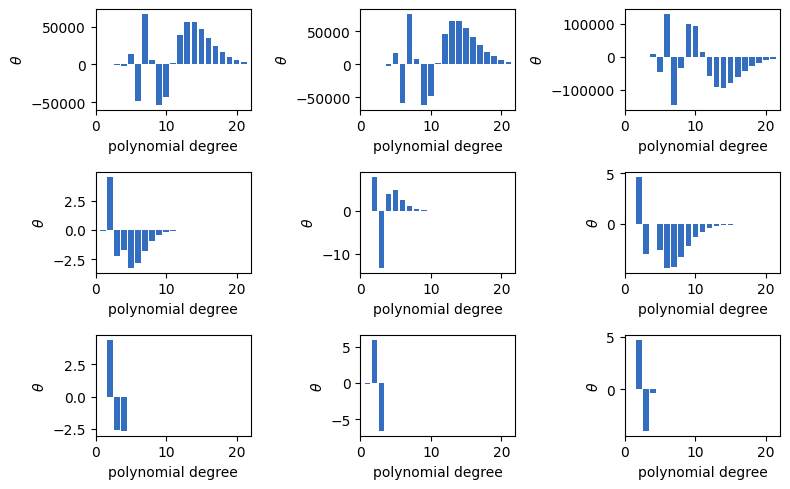

In [5]:
fig = plt.figure(dpi=100, figsize=(8,5), tight_layout=True)
axs = fig.subplots(3,3)
axs = axs.reshape(-1)

axs[0].bar(range(1, degree+2), lin_params[1],alpha=1,color=colorb)
axs[1].bar(range(1, degree+2), lin_params[9],alpha=1,color=colorb)
axs[2].bar(range(1, degree+2), lin_params[-1],alpha=1,color=colorb)
axs[3].bar(range(1, degree+2), ridge_params[1],color=colorb)
axs[4].bar(range(1, degree+2), ridge_params[9],color=colorb)
axs[5].bar(range(1, degree+2), ridge_params[-1],color=colorb)
axs[6].bar(range(1, degree+2), lasso_params[1],color=colorb)
axs[7].bar(range(1, degree+2), lasso_params[9],color=colorb)
axs[8].bar(range(1, degree+2), lasso_params[-1],color=colorb)
for ax in axs:
    ax.set_xlim(0,22)
    ax.set_ylabel('$\\theta$')
    ax.set_xlabel('polynomial degree')
plt.show()

In order to proceed to the evaluation of the three cross-validated models, we compute the average of the parameters obtained from the optimization performed at each fold

In [6]:
# Compute models based on the mean over the 100-fold cross-validation
lin_theta = np.mean(lin_params[:,:],0)
lasso_theta = np.mean(lasso_params[:,:],0)
ridge_theta = np.mean(ridge_params[:,:],0)
# Set mean params for each model
lin_reg.coef_ = lin_theta[1:]
lin_reg.intercept_ = lin_theta[0]
ridge.coef_ = ridge_theta[1:]
ridge.intercept_ = ridge_theta[0]
lasso.coef_ = lasso_theta[1:]
lasso.intercept_ = lasso_theta[0]
# Predictions within interpolation range
fy_lin_xi = lin_reg.predict(xi_poly)
fy_la_xi = lasso.predict(xi_poly)
fy_rid_xi = ridge.predict(xi_poly)
# Predictions within extrapolation range
fy_la_xe = lasso.predict(xe_poly)
fy_lin_xe = lin_reg.predict(xe_poly)
fy_rid_xe = ridge.predict(xe_poly)

The first Figure below compares the performances of the three models (pinv, LASSO, Ridge) in terms of the mean squared error, while Figure second one shows the predictions, in the interpolation and extrapolation range.

As we might have expected, LASSO excels over all other strategies by providing a model that can interpolate (without overfitting) and, even, extrapolate with good accuracy. We can also observe that Ridge performs better than the standard regression approach, although it rapidly fails in the extrapolation range.

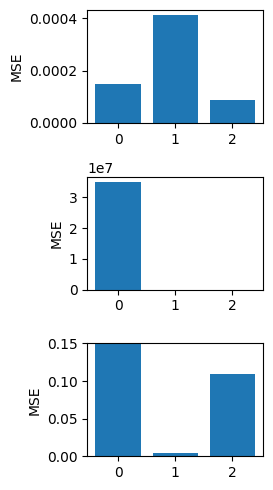

In [7]:
# compute MSE and plot
erri = np.array([mean_squared_error(ytrain,fy_lin_xi),
                mean_squared_error(ytrain,fy_la_xi),
                mean_squared_error(ytrain,fy_rid_xi),
                ])

erre = np.array([mean_squared_error(ytest,fy_lin_xe),
                mean_squared_error(ytest,fy_la_xe),
                mean_squared_error(ytest,fy_rid_xe),
                ])

fig = plt.figure(dpi=100, figsize=(7/3+0.5,5),tight_layout=True)
axs = fig.subplots(3)
axs = axs.reshape(-1)
axs[0].bar(range(3), erri)
axs[1].bar(range(3), erre)
axs[2].bar(range(3), erre)
axs[2].set_ylim(0,0.15)
for ax in axs:
    ax.set_ylabel('MSE')

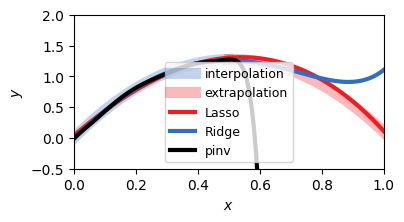

In [8]:
fig = plt.figure(dpi=100, figsize=(4, 2.))
axs = fig.subplots(1)

axs.plot(xi,ytrain,color=colorb,linewidth=8,alpha=0.3,label='interpolation')
axs.plot(xe,ytest,color=colorr,linewidth=8,alpha=0.3,label='extrapolation')

axs.plot(xi,fy_la_xi,alpha=1,color=colorr,linewidth=3,label='Lasso')
axs.plot(xe,fy_la_xe,alpha=1,color=colorr,linewidth=3)

axs.plot(xi,fy_rid_xi,alpha=1,color=colorb,linewidth=3,label='Ridge')
axs.plot(xe,fy_rid_xe,alpha=1,color=colorb,linewidth=3)

axs.plot(xi,fy_lin_xi,alpha=1,color='black',linewidth=3,label='pinv')
axs.plot(xe,fy_lin_xe,alpha=1,color='black',linewidth=3)


axs.set_xlim(0,1)
axs.set_ylim(-0.5,2)
axs.legend(loc='best',fontsize="9")
axs.set_ylabel('$y$')
axs.set_xlabel('$x$')
plt.show() 